In [1]:
import numpy as np
import pandas as pd
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")

In [2]:
train_data.shape

(1460, 81)

In [3]:
test_data.shape

(1459, 80)

In [5]:
# Function to drop columns with high missing rate ()
def drop_missing_columns (data, missing_threshold = 0.98):
    data_copy = data.copy()
    missing_columns = []
    number_of_row = data_copy.shape[0]
    for col in data_copy.columns:
        # calculate number of missing row in each column
        missing_row = data_copy[col].isnull().sum()
        missing_frac = missing_row / float(number_of_row)
        if missing_frac > missing_threshold:
            missing_columns.append(col)
    keep_columns = [col for col in data_copy.columns if col not in missing_columns]   
    keep_data = data_copy[keep_columns].copy()
    return keep_data, missing_columns
 

In [6]:
keep_data, missing_columns = drop_missing_columns(train_data,missing_threshold = 0)

In [7]:
missing_columns

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [8]:
# Assume poolQC missing values are due to property not having pool (which makes sense for the data )
values = {
    "LotFrontage": 0,
    "Alley": "No alley access",
    "MasVnrType": "No Veneer",
    "MasVnrArea": 0,
    "BsmtQual": "No Basement",
    "BsmtCond": "No Basement",
    "BsmtExposure": "No Basement",
    "BsmtFinType1": "Not Applicable",
    "BsmtFinType2": "Not Applicable",
    "FireplaceQu": "No Fireplace",
    "GarageType": "No Garage",
    "GarageYrBlt": "None built",
    "GarageFinish": "No Garage",
    "GarageQual": "No Garage",
    "GarageCond": "No Garage",
    "PoolQC": "No Pool",
    "Fence": "No Fence",
    "MiscFeature": "No Feature",    
    "GarageArea": 0,
}


In [9]:
train_data.fillna(value=values, inplace=True)

In [10]:
train_data.isna().sum().sort_values(ascending=False)

Electrical     1
CentralAir     0
GarageYrBlt    0
GarageType     0
FireplaceQu    0
              ..
MasVnrArea     0
MasVnrType     0
Exterior2nd    0
Exterior1st    0
SalePrice      0
Length: 81, dtype: int64

In [11]:
features = train_data.select_dtypes(include=["object"]).columns

In [12]:
features

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [13]:
for features in features:
    train_data[features].fillna(train_data[features].mode()[0], inplace=True)

In [14]:
# some basement values are set to NANs when they should be zero
Basementmetrics = [
    "BsmtHalfBath",
    "BsmtFullBath",
    "BsmtFinSF1",
    "GarageCars",
    "TotalBsmtSF",
    "BsmtUnfSF",
    "BsmtFinSF2",
]

In [15]:
for Basementmetrics in Basementmetrics:
    train_data.loc[(train_data[Basementmetrics].isnull()), Basementmetrics] = 0


In [16]:
train_data.loc[(train_data.GarageCars.isnull()), "GarageCars"] = 0

In [17]:
# Change variable types

# Year built is currently an integer we should treat this as a category for the purpose of this task

train_data.YearBuilt = train_data.YearBuilt.astype(str)


train_data.YrSold = train_data.YrSold.astype(str)

train_data.GarageYrBlt = train_data.GarageYrBlt.astype(str)


train_data.YearRemodAdd = train_data.YearRemodAdd.astype(str)


# MSSUbCLass, Overallcond & OverallQual: we will decode this to avoid numeric mix-up
MSSUbCLass = {
    20: "1-STORY 1946 & NEWER ALL STYLES",
    30: "1-STORY 1945 & OLDER",
    40: "1-STORY W/FINISHED ATTIC ALL AGES",
    45: "1-1/2 STORY - UNFINISHED ALL AGES",
    50: "1-1/2 STORY FINISHED ALL AGES",
    60: "2-STORY 1946 & NEWER",
    70: "2-STORY 1945 & OLDER",
    75: "2-1/2 STORY ALL AGES",
    80: "SPLIT OR MULTI-LEVEL",
    85: "SPLIT FOYER",
    90: "DUPLEX - ALL STYLES AND AGES",
    120: "1-STORY PUD (Planned Unit Development) - 1946 & NEWER",
    150: "1-1/2 STORY PUD - ALL AGES",
    160: "2-STORY PUD - 1946 & NEWER",
    180: "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER",
    190: "2 FAMILY CONVERSION - ALL STYLES AND AGES",
}


OverallQualCond = {
    10: "Very Excellent",
    9: "Excellent",
    8: "Very Good",
    7: "Good",
    6: "Above Average",
    5: "Average",
    4: "Below Average",
    3: "Fair",
    2: "Poor",
    1: "Very Poor",
}


train_data.replace(
    {
        "OverallQual": OverallQualCond,
        "OverallCond": OverallQualCond,
        "MSSubClass": MSSUbCLass,
    },
    inplace=True,
)


In [18]:
train_data["MSSubClass"]

0                  2-STORY 1946 & NEWER
1       1-STORY 1946 & NEWER ALL STYLES
2                  2-STORY 1946 & NEWER
3                  2-STORY 1945 & OLDER
4                  2-STORY 1946 & NEWER
                     ...               
1455               2-STORY 1946 & NEWER
1456    1-STORY 1946 & NEWER ALL STYLES
1457               2-STORY 1945 & OLDER
1458    1-STORY 1946 & NEWER ALL STYLES
1459    1-STORY 1946 & NEWER ALL STYLES
Name: MSSubClass, Length: 1460, dtype: object

In [19]:
train_data.describe()

,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,57.623288,10516.828082,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,180921.195890
std,421.610009,34.664304,9981.264932,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,79442.502883
min,1.000000,0.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,34900.000000
25%,365.750000,42.000000,7553.500000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,129975.000000
50%,730.500000,63.000000,9478.500000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,163000.000000
75%,1095.250000,79.000000,11601.500000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,214000.000000
max,1460.000000,313.000000,215245.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,755000.000000


In [20]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

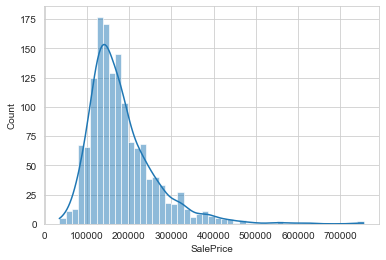

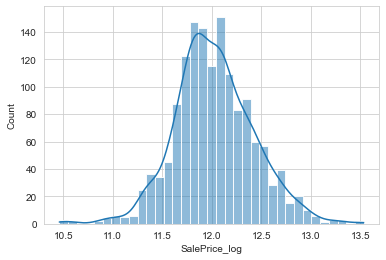

In [21]:
# Plot distributions of sale price and log of sale price
sns.set_style("whitegrid")
sns.histplot(train_data.SalePrice, kde = True)
plt.show()

train_data["SalePrice_log"] = np.log(train_data.SalePrice)
sns.histplot(train_data.SalePrice_log, kde=True)
plt.show()


<AxesSubplot:>

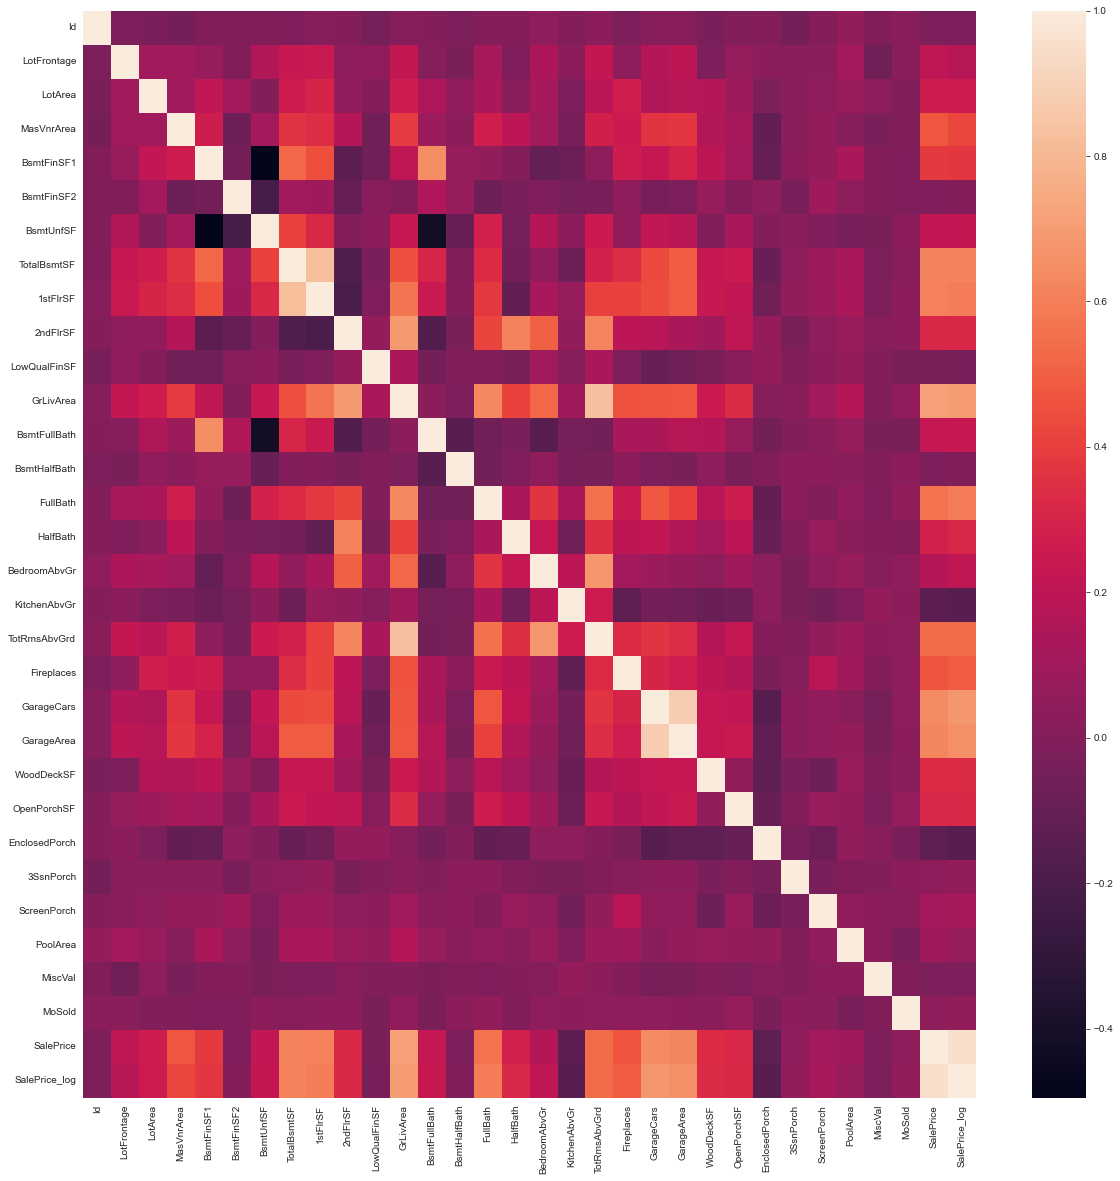

In [22]:
# Plot the heatmap: the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(train_data.corr())

In [23]:
# Calculate correlation of the other variables and log of sale price
corr_mat = train_data.corr()
select_features = corr_mat["SalePrice"]>0.15

In [24]:
omit_columns = []
numeric_features = train_data.select_dtypes(include=np.number).columns
for col in numeric_features:
    if abs(corr_mat[col]["SalePrice"]) < 0.15:
        omit_columns.append(col)
omit_columns

['Id',
 'BsmtFinSF2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold']

In [25]:
omit_columns.extend(["SalePrice", "SalePrice_log"])
omit_columns

['Id',
 'BsmtFinSF2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'SalePrice',
 'SalePrice_log']

In [26]:
# Convert training and testing data to one hot encoded numeric data
import sklearn
# Create a onehotencoder object that relables columns after transforming
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder


# Wrapper for one hot encoder to allow labelling of encoded variables
class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(
            sparse_matrix.toarray(), columns=new_columns, index=X.index
        )
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f"{column}_<{self.categories_[i][j]}>")
                j += 1
        return new_columns


# Define funtion to encode categorrical variables with and rejoin to initial data


def transform(Train, df):

    # isolate categorical features
    cat_columns = df.select_dtypes(include=["object"]).columns
    cat_df = df[cat_columns]

    # isolate the numeric features
    numeric_df = df.select_dtypes(include=np.number)

    # initialise one hot encoder object spcify handle unknown and auto options to keep test and train same size
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    # Fit the endcoder to training data
    ohe.fit(Train[cat_columns])

    # transform input data
    df_processed = ohe.transform(cat_df)

    # concatinate numeric features from orginal tables with encoded features
    df_processed_full = pd.concat([df_processed, numeric_df], axis=1)

    return df_processed_full

In [27]:
# Transform training data to numeric form
train_encoded = transform(train_data, train_data)

In [28]:
train_encoded["SalePrice_log"] = np.log(train_encoded.SalePrice)

In [29]:
# split train.csv into training and test set
from sklearn.model_selection import train_test_split
X = train_encoded.drop(columns=omit_columns)
y = train_encoded.SalePrice_log

In [30]:
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size=0.2)

In [31]:
X_train.shape

(1168, 596)

In [32]:
y_train.shape

(1168,)

In [33]:

import time

from sklearn.model_selection import GridSearchCV


# This function use to tune the model with GridSearchCV and cv = 5


def model_pipeline(model, param_grid, scoring):
    tuned_model = GridSearchCV(
        estimator=model, param_grid=param_grid, scoring=scoring, cv=5
    )

    # Fit model and calculate the time of the trainng process 
    print("Running model...")
    start_time = time.process_time()

    tuned_model.fit(X_train, y_train)

    # End of fit time
    print(time.process_time() - start_time, "Seconds")
    print("Finished running model")
    return tuned_model


# Plot the best model


def plot_mean_scores(tuned_model, col, x, y, name):

    results = pd.DataFrame(tuned_model.cv_results_)
    best_result = results.loc[results.rank_test_score == 1]

    # Initialize a grid of plots
    sns.set(font_scale=1.5)
    sns.set_style("darkgrid")
    col = col
    for col in col:
        grid = sns.FacetGrid(
            results,
            col=col,
            hue="rank_test_score",
            palette="tab20c",
            legend_out=False,
            col_wrap=5,
            height=15,
        )

        # Draw a horizontal line to show the starting point
        grid.map(plt.axhline, y=0, ls=":", c=".5")

        # Draw marker on plot and decide what parameters to plot
        grid.map(sns.scatterplot, x, y, marker="o", s=200)

        # Adjust the arrangement of the plots
        grid.fig.tight_layout(w_pad=1)

        # Add legend to gird
        grid.add_legend()

    grid.savefig(name)

In [37]:
np.arange(0.1, 0.8,0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

In [48]:
np.arange(5,35,5)

array([ 5, 10, 15, 20, 25, 30])

Running model...
6.96875 Seconds
Finished running model


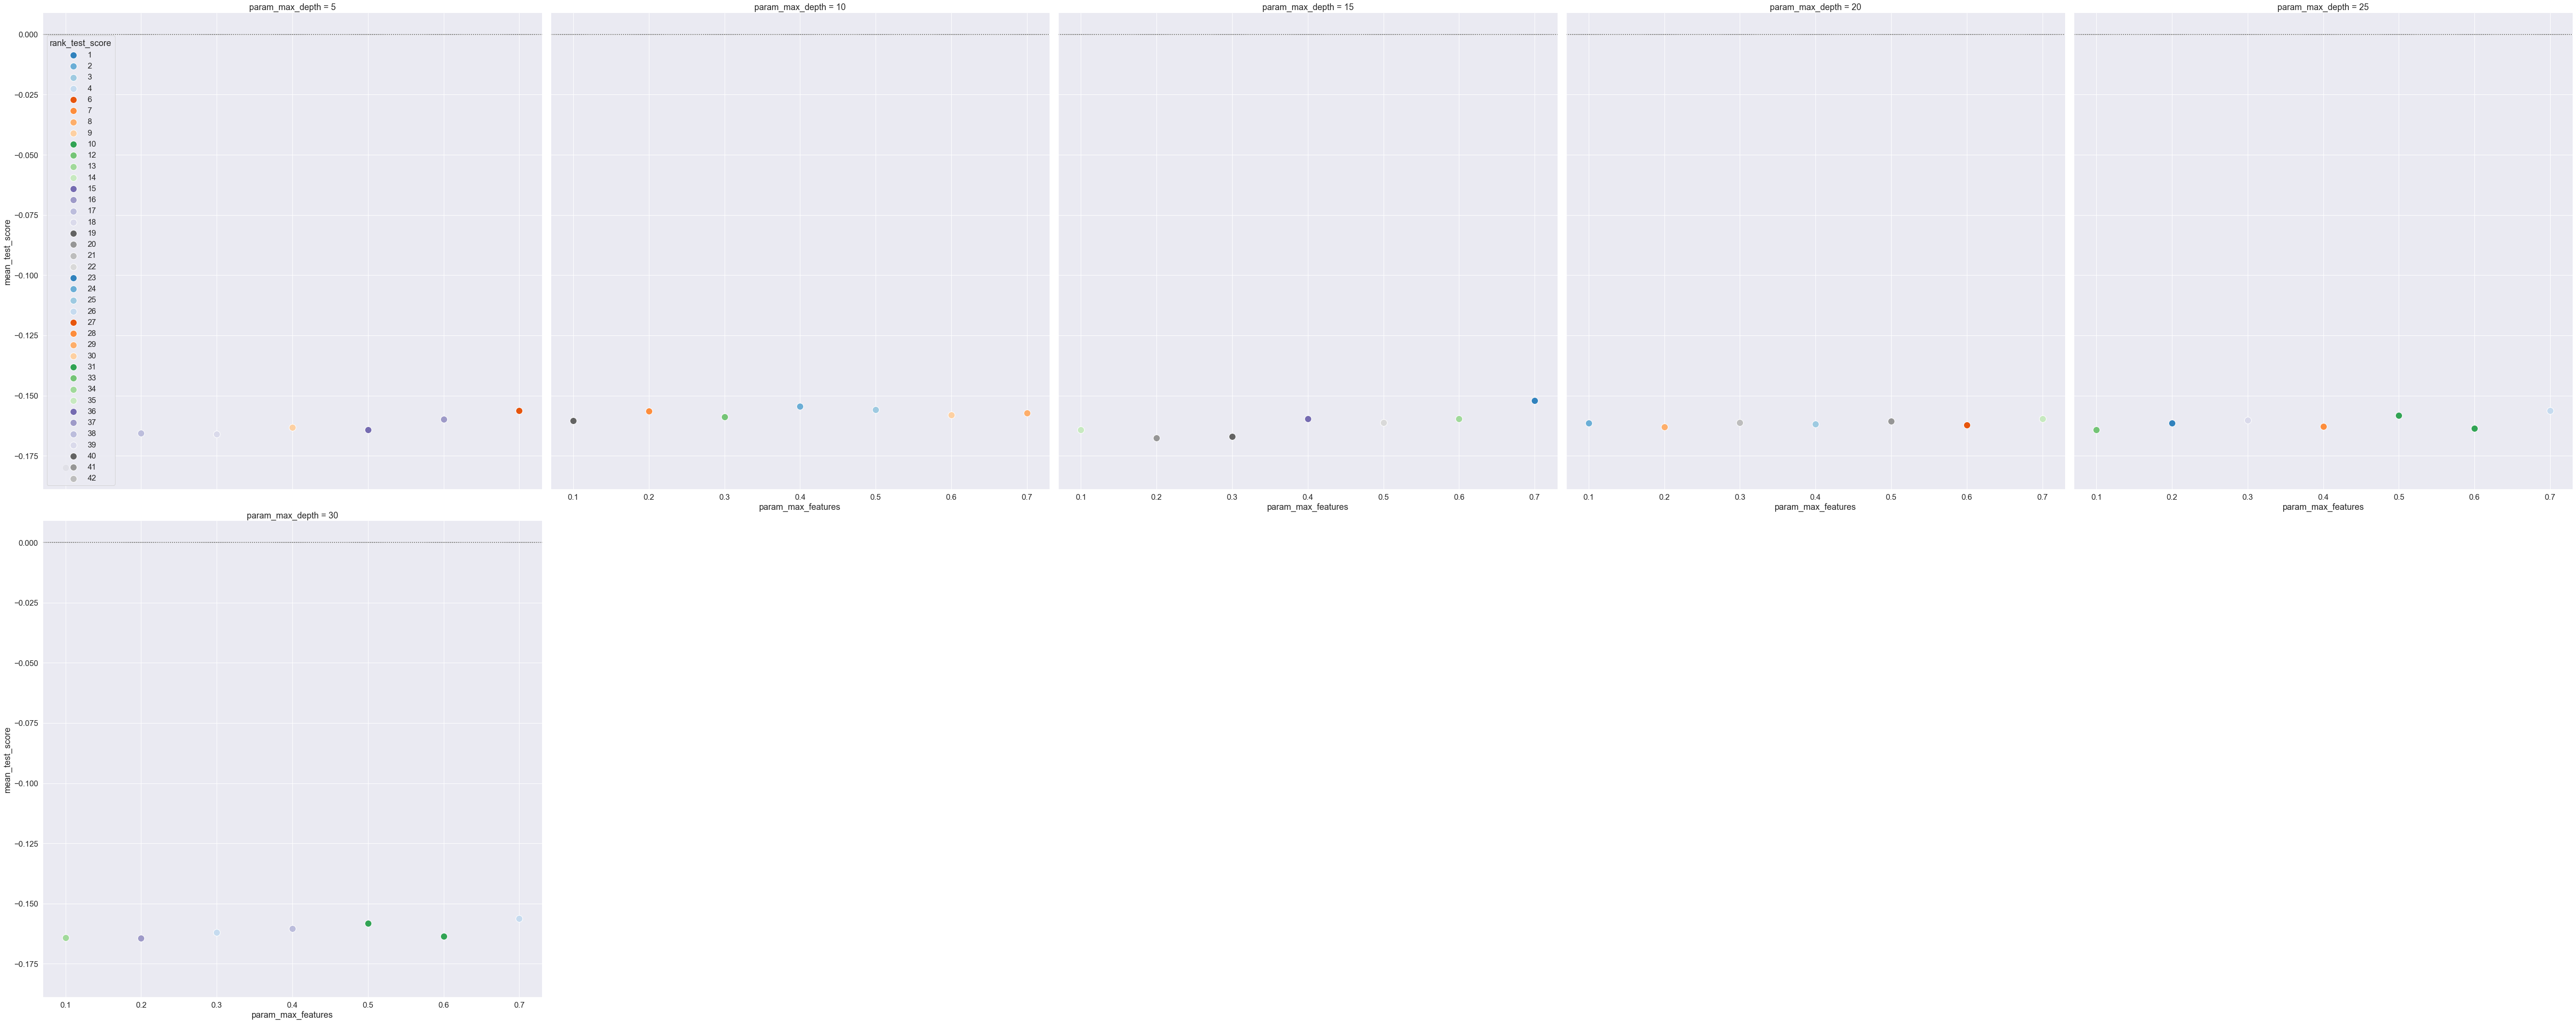

In [38]:
# Fit decision tree model and fine-tune the parameter
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
import matplotlib.pyplot as plt
# Build a decision tree
# Set paramters for Grid Search CV
param_grid = {
    "max_depth": np.arange(5,35,5),
    "max_features": np.arange(0.1, 0.8,0.1)
}
tree_model = DecisionTreeRegressor(criterion="mse", random_state=0)

tree_tuned_model = model_pipeline(tree_model, param_grid, "neg_mean_absolute_error")
plot_mean_scores(
    tree_tuned_model,
    ["param_max_depth"],
    "param_max_features",
    "mean_test_score",
    "DecisionTree",
)

In [40]:
tree_tuned_model.best_params_, tree_tuned_model.best_score_

({'max_depth': 15, 'max_features': 0.7000000000000001}, -0.15214090866615362)

In [49]:
np.arange(100,700,100)

array([100, 200, 300, 400, 500, 600])

Running model...
145.078125 Seconds
Finished running model


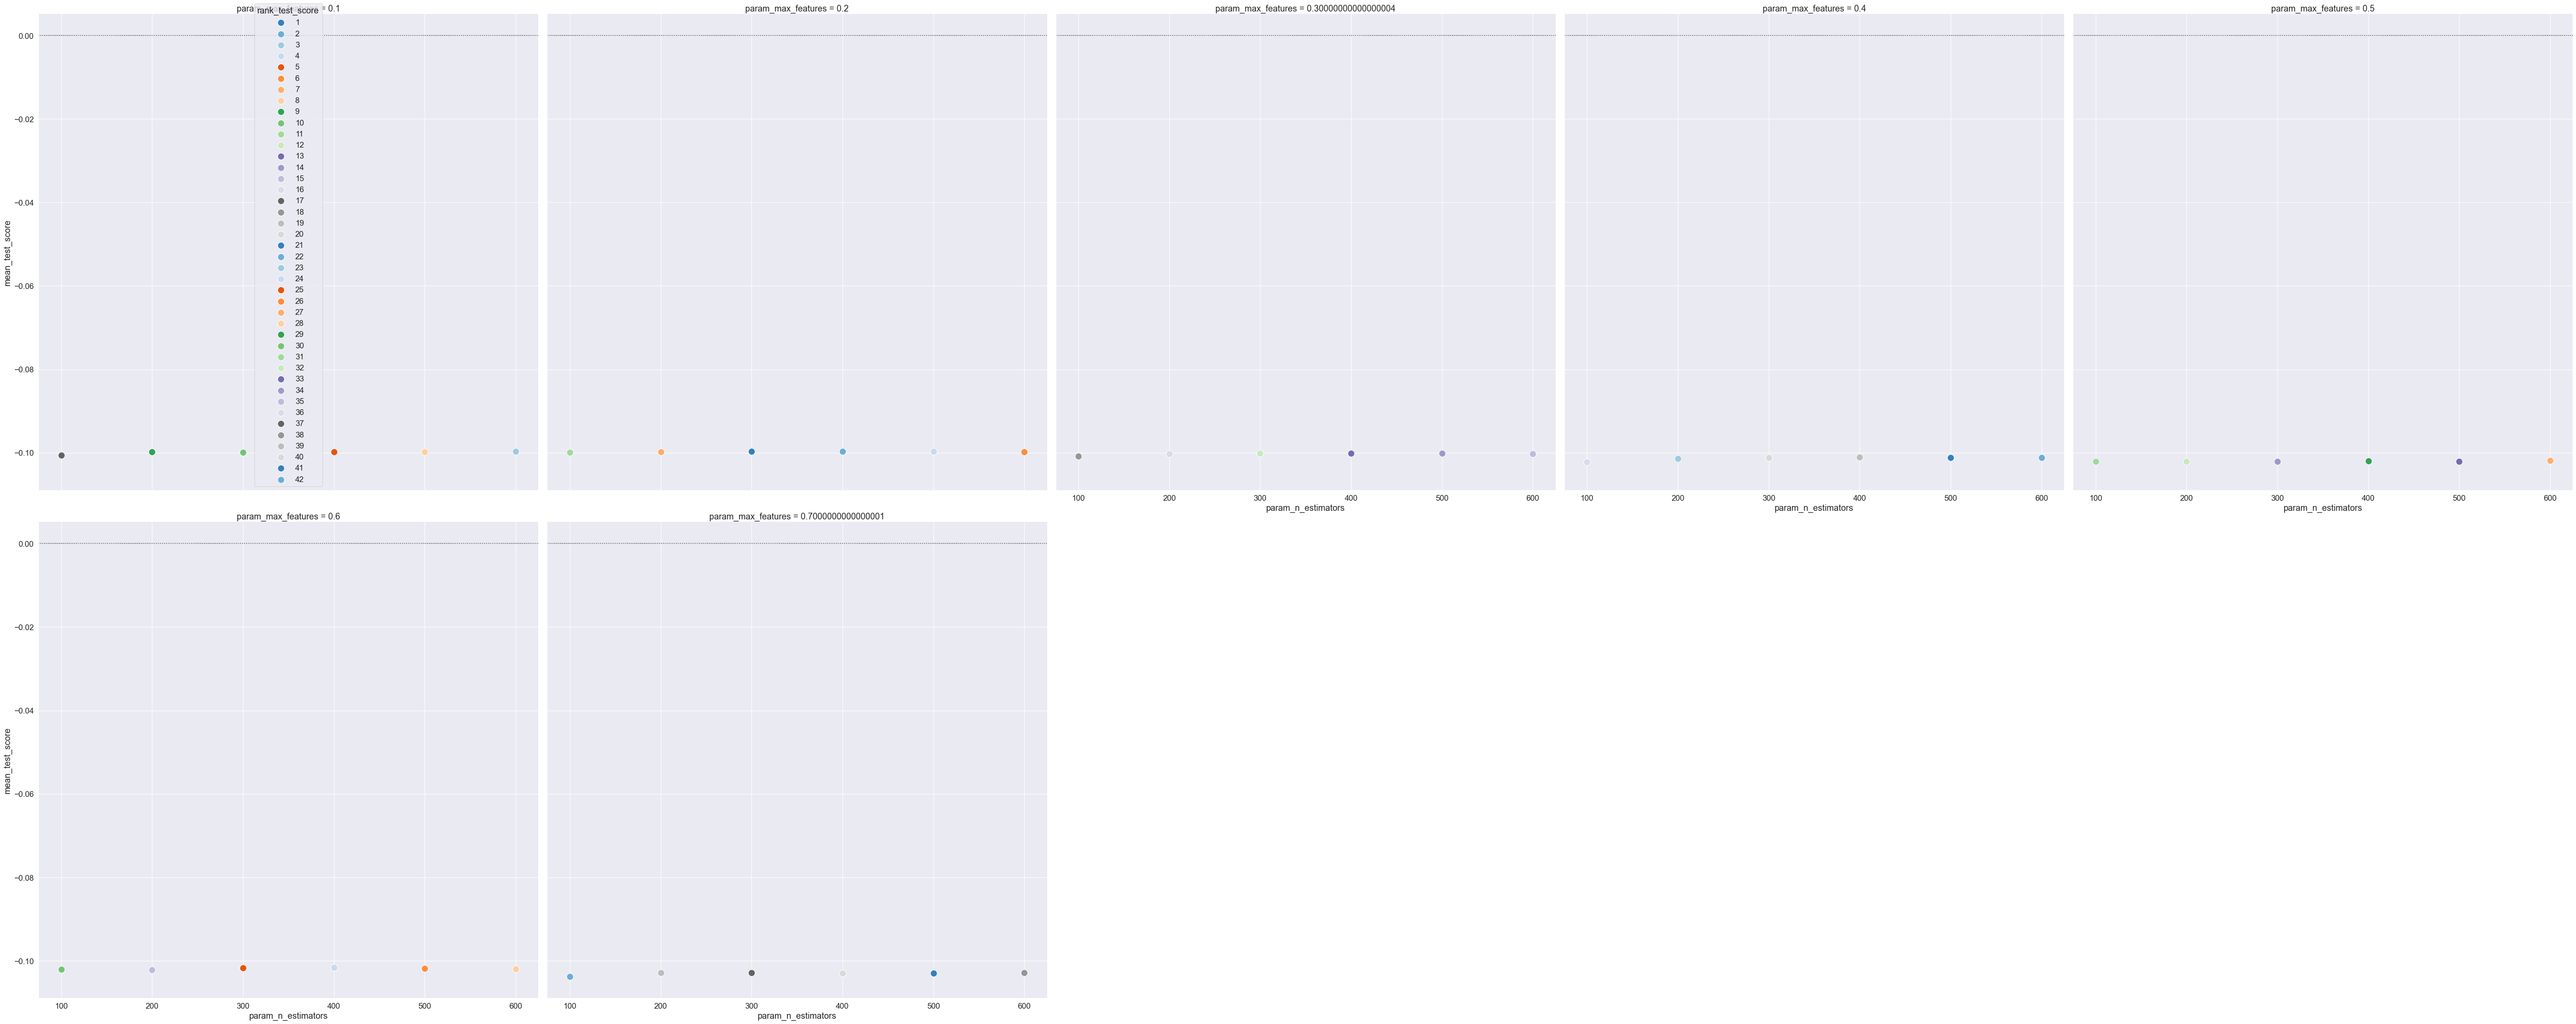

In [41]:
# Model 2: Random Forest
from sklearn.ensemble import RandomForestRegressor

# Set paramters for Grid Search
param_grid = {
    "n_estimators": np.arange(100,700,100),
    "max_features": np.arange(0.1, 0.8,0.1),
}
# Initialise the random forest model
rand_forest_reg = RandomForestRegressor(n_jobs=-1, random_state=0, bootstrap=True)

rand_forest_tuned_model = model_pipeline(rand_forest_reg, param_grid, "neg_mean_absolute_error")
plot_mean_scores(
    rand_forest_tuned_model,
    ["param_max_features"],
    "param_n_estimators",
    "mean_test_score",
    "RandomForest",
)

In [42]:
rand_forest_tuned_model.best_params_, rand_forest_tuned_model.best_score_

({'max_features': 0.2, 'n_estimators': 300}, -0.09966299436802066)

In [46]:
rand_forest_tuned_model.cv_results_

{'mean_fit_time': array([1.01386452, 0.55482235, 0.72581434, 0.80928111, 1.02378626,
        1.21238089, 0.39645696, 0.63447614, 0.909199  , 1.0730998 ,
        1.34490504, 1.62808847, 0.45820279, 0.80029798, 1.05937462,
        1.36831784, 1.58789368, 2.02659211, 0.52601027, 0.87858534,
        1.26316342, 1.61771235, 1.94469185, 2.33968306, 0.57944565,
        1.02898808, 1.44587083, 1.85737181, 2.27321105, 2.71676054,
        0.6552875 , 1.14819326, 1.66319833, 2.10681624, 2.73315449,
        3.30723619, 0.78820963, 1.33777561, 1.82212157, 2.36532073,
        2.97850289, 3.550282  ]),
 'std_fit_time': array([1.29605694, 0.02325176, 0.05837991, 0.00563242, 0.06154646,
        0.00941726, 0.00737438, 0.00997875, 0.04208319, 0.03660726,
        0.05330383, 0.01562792, 0.01488417, 0.04845946, 0.0135142 ,
        0.0508084 , 0.01521248, 0.11395732, 0.01389915, 0.01185124,
        0.03663366, 0.07439706, 0.06812528, 0.0572098 , 0.01930392,
        0.03370671, 0.03561937, 0.06823587, 0.070

Running model...
605.21875 Seconds
Finished running model


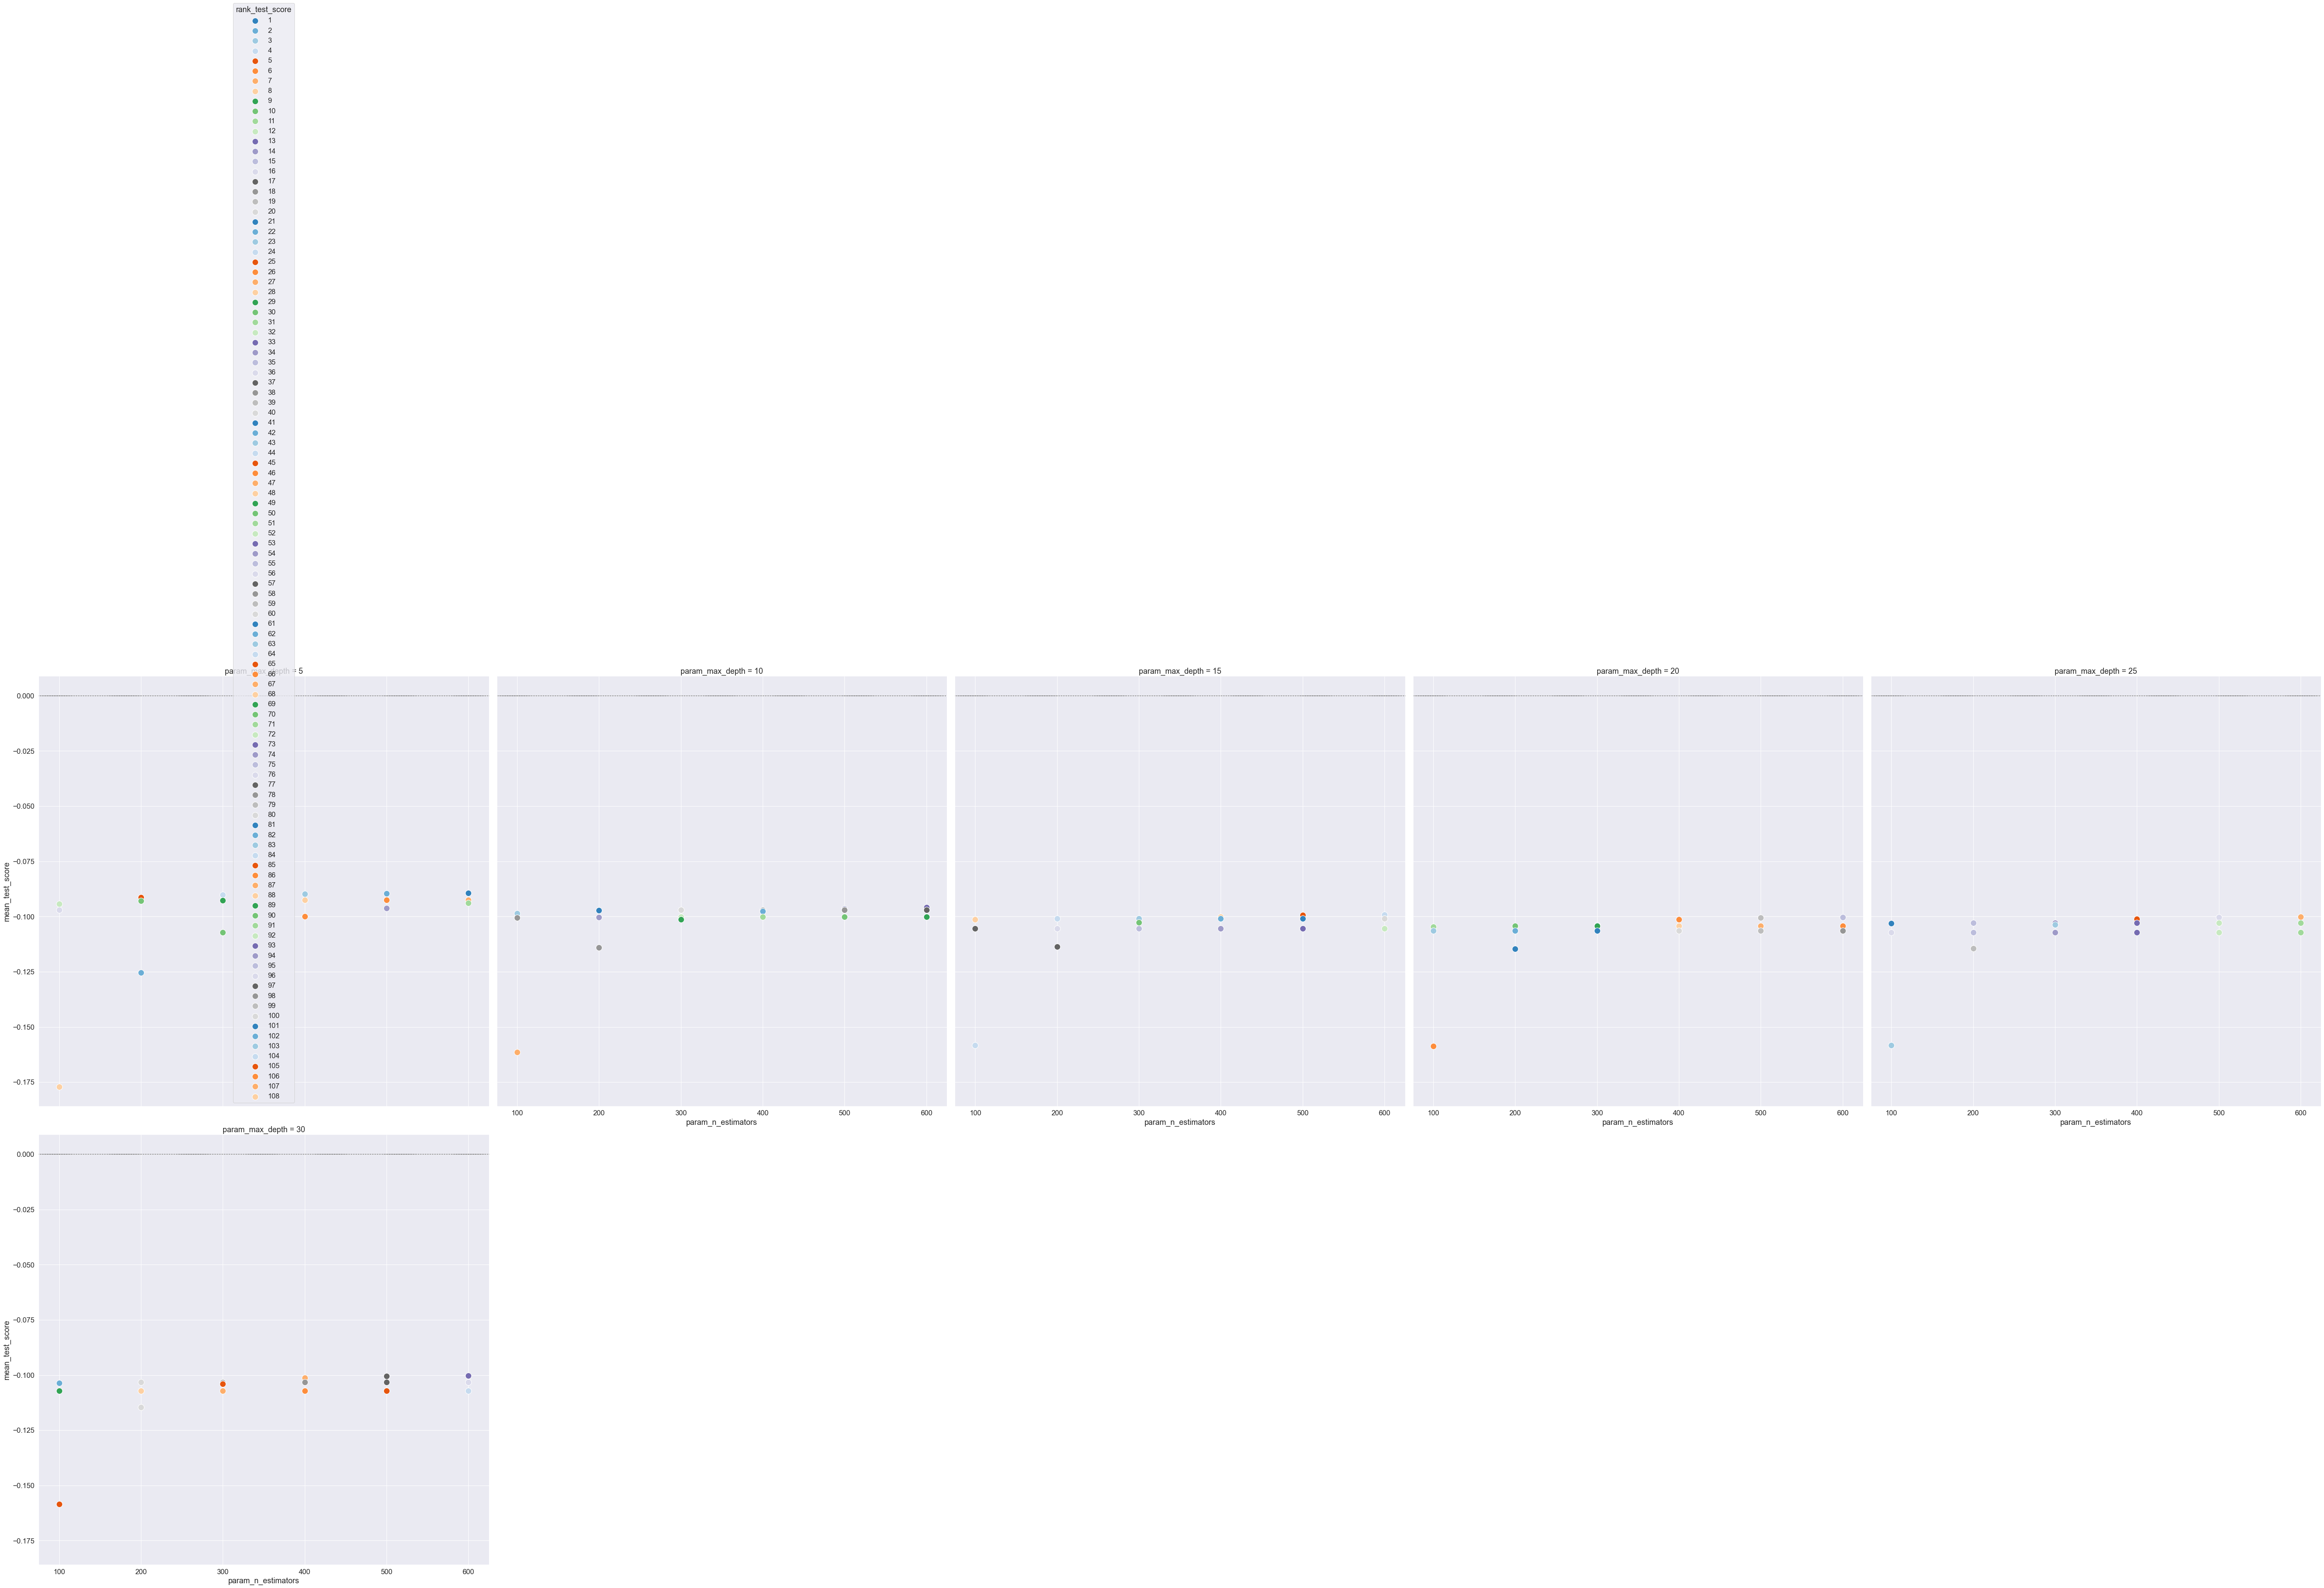

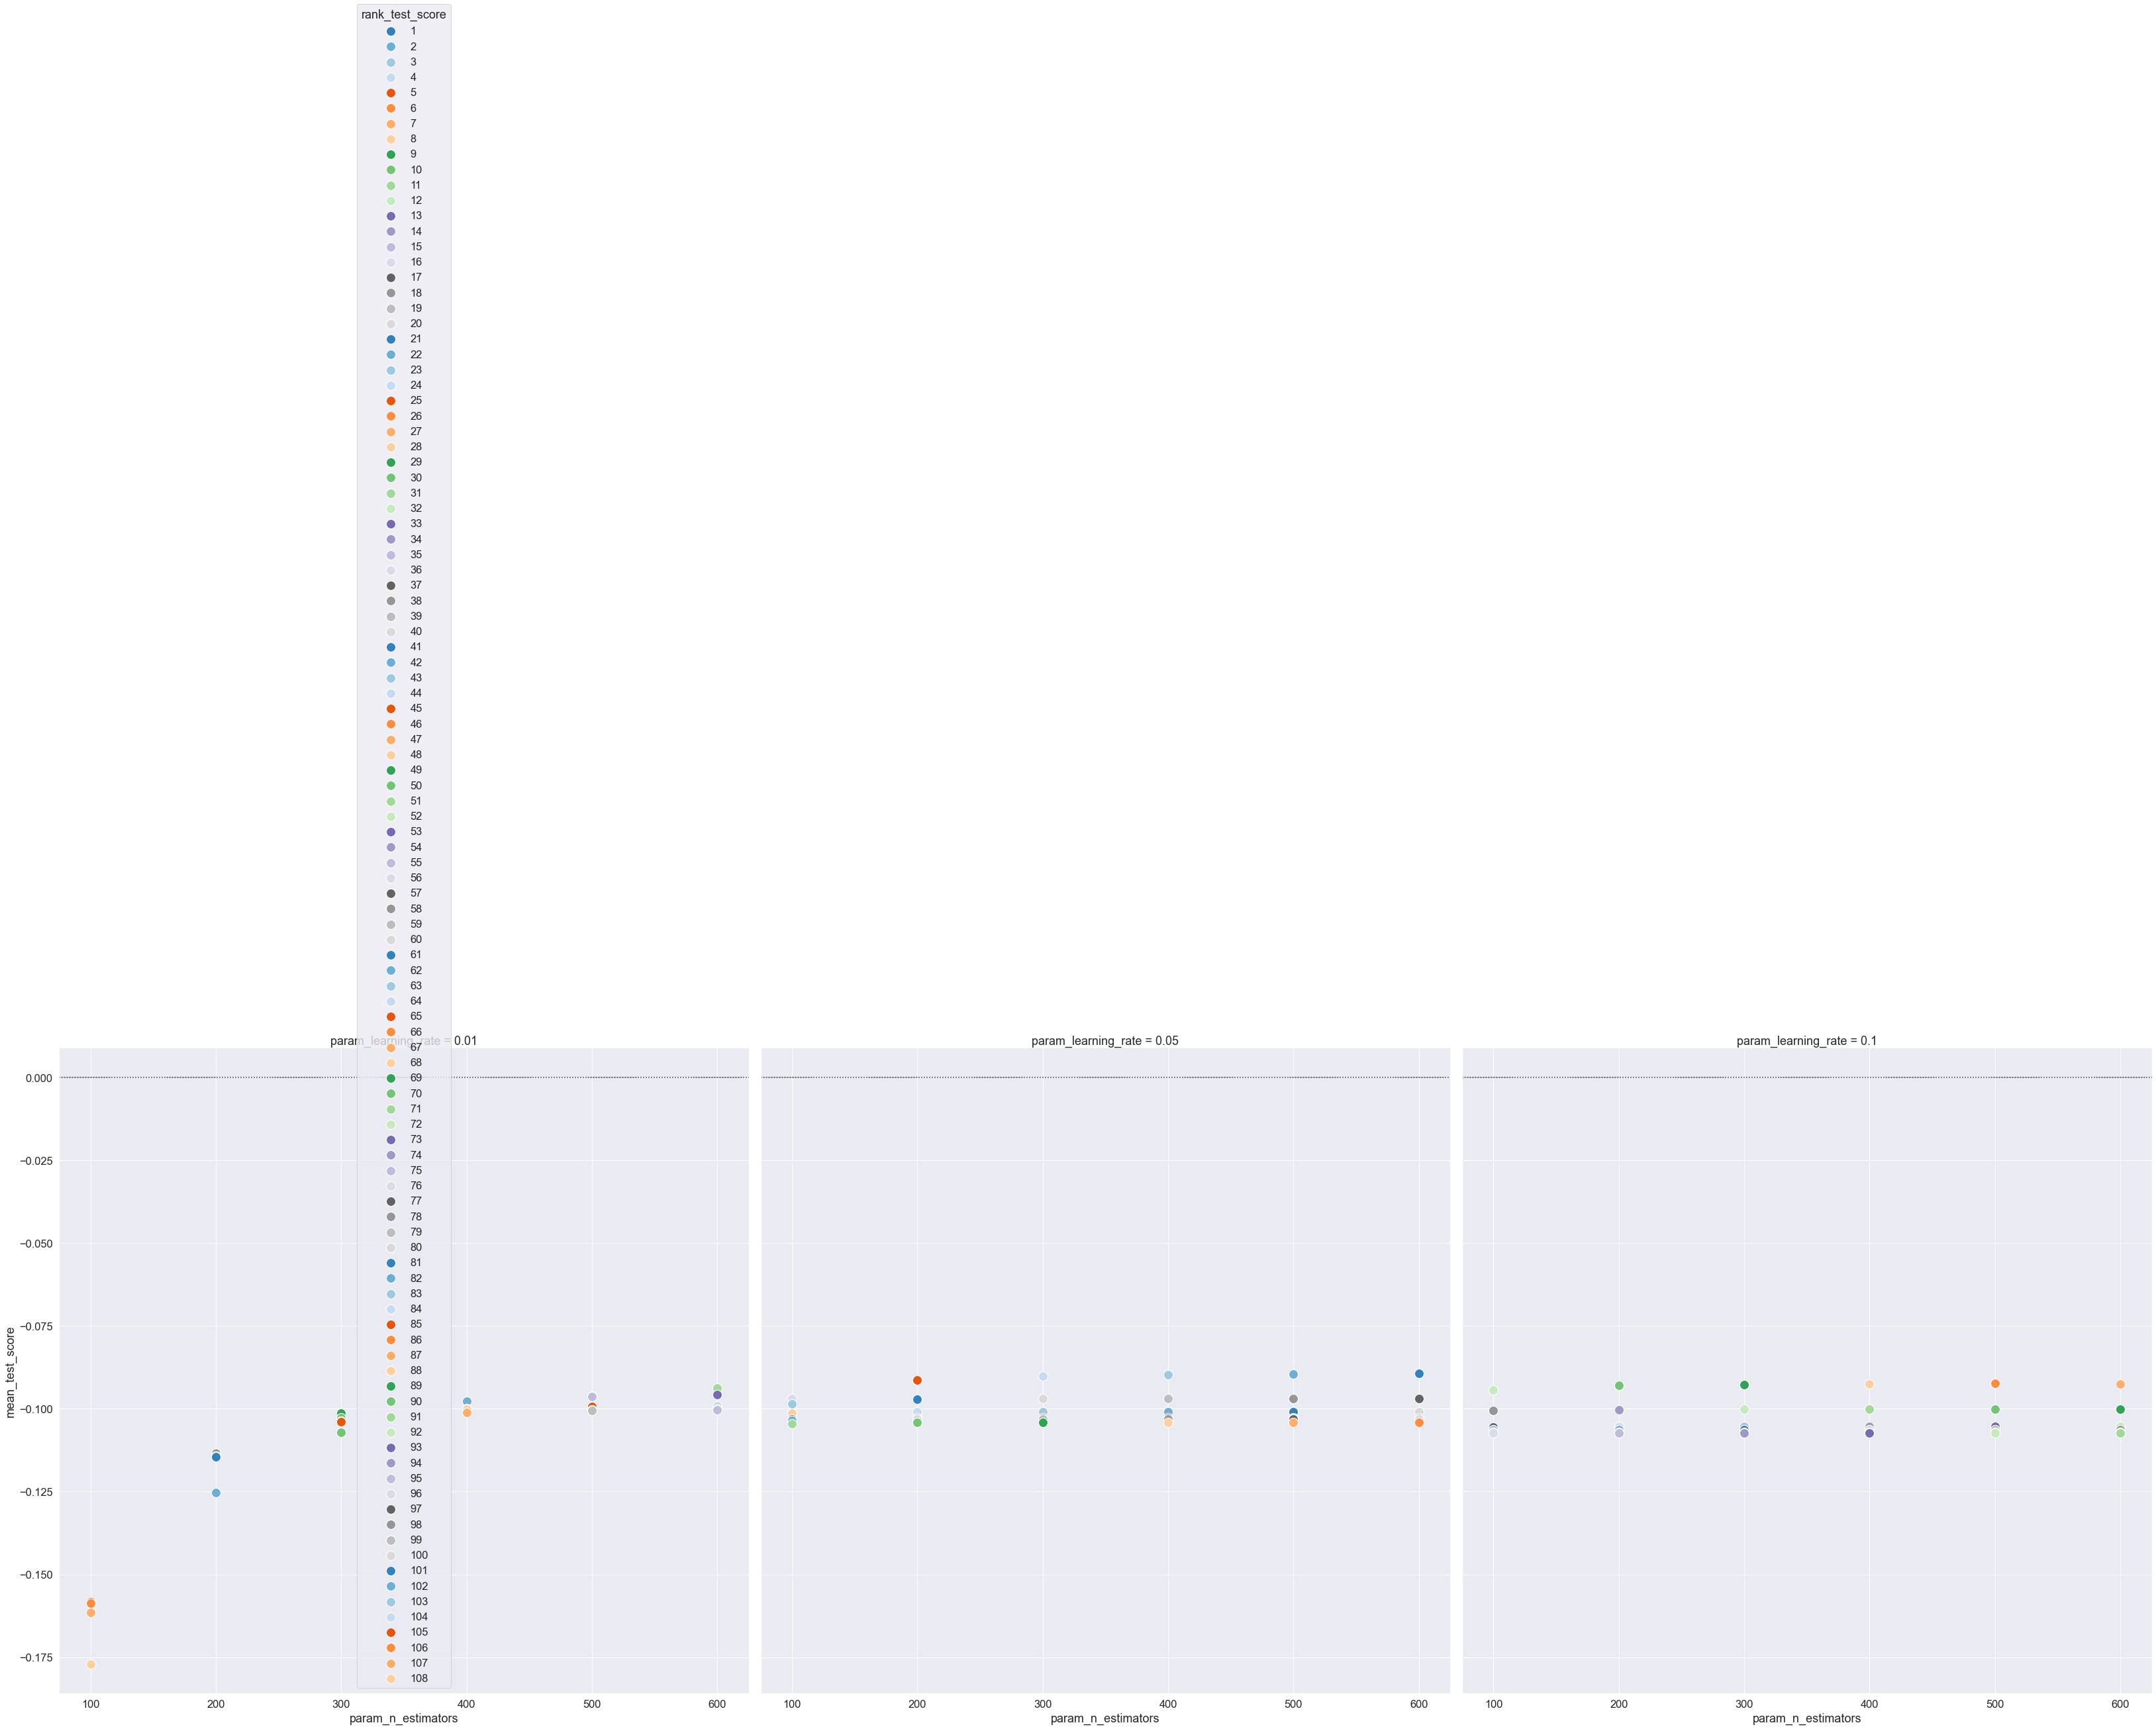

In [43]:
# Model 3: Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

# Set paramters for Grid Search CV
param_grid = {
    "n_estimators": np.arange(100,700,100),
    "max_depth": np.arange(5,35,5),
    "learning_rate": [0.01, 0.05, 0.1],
}
gra_boost = GradientBoostingRegressor(random_state=0, max_features="sqrt")

gra_boost_tuned_model = model_pipeline(gra_boost, param_grid, "neg_mean_absolute_error")
plot_mean_scores(
    gra_boost_tuned_model,
    ["param_max_depth", "param_learning_rate"],
    "param_n_estimators",
    "mean_test_score",
    "GradientBoosting",
)

In [44]:
gra_boost_tuned_model.best_params_, gra_boost_tuned_model.best_score_

({'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 600},
 -0.08930796342548727)

In [50]:
rand_forest_tuned_model.best_params_,rand_forest_tuned_model.best_score_

({'max_features': 0.2, 'n_estimators': 300}, -0.09966299436802066)

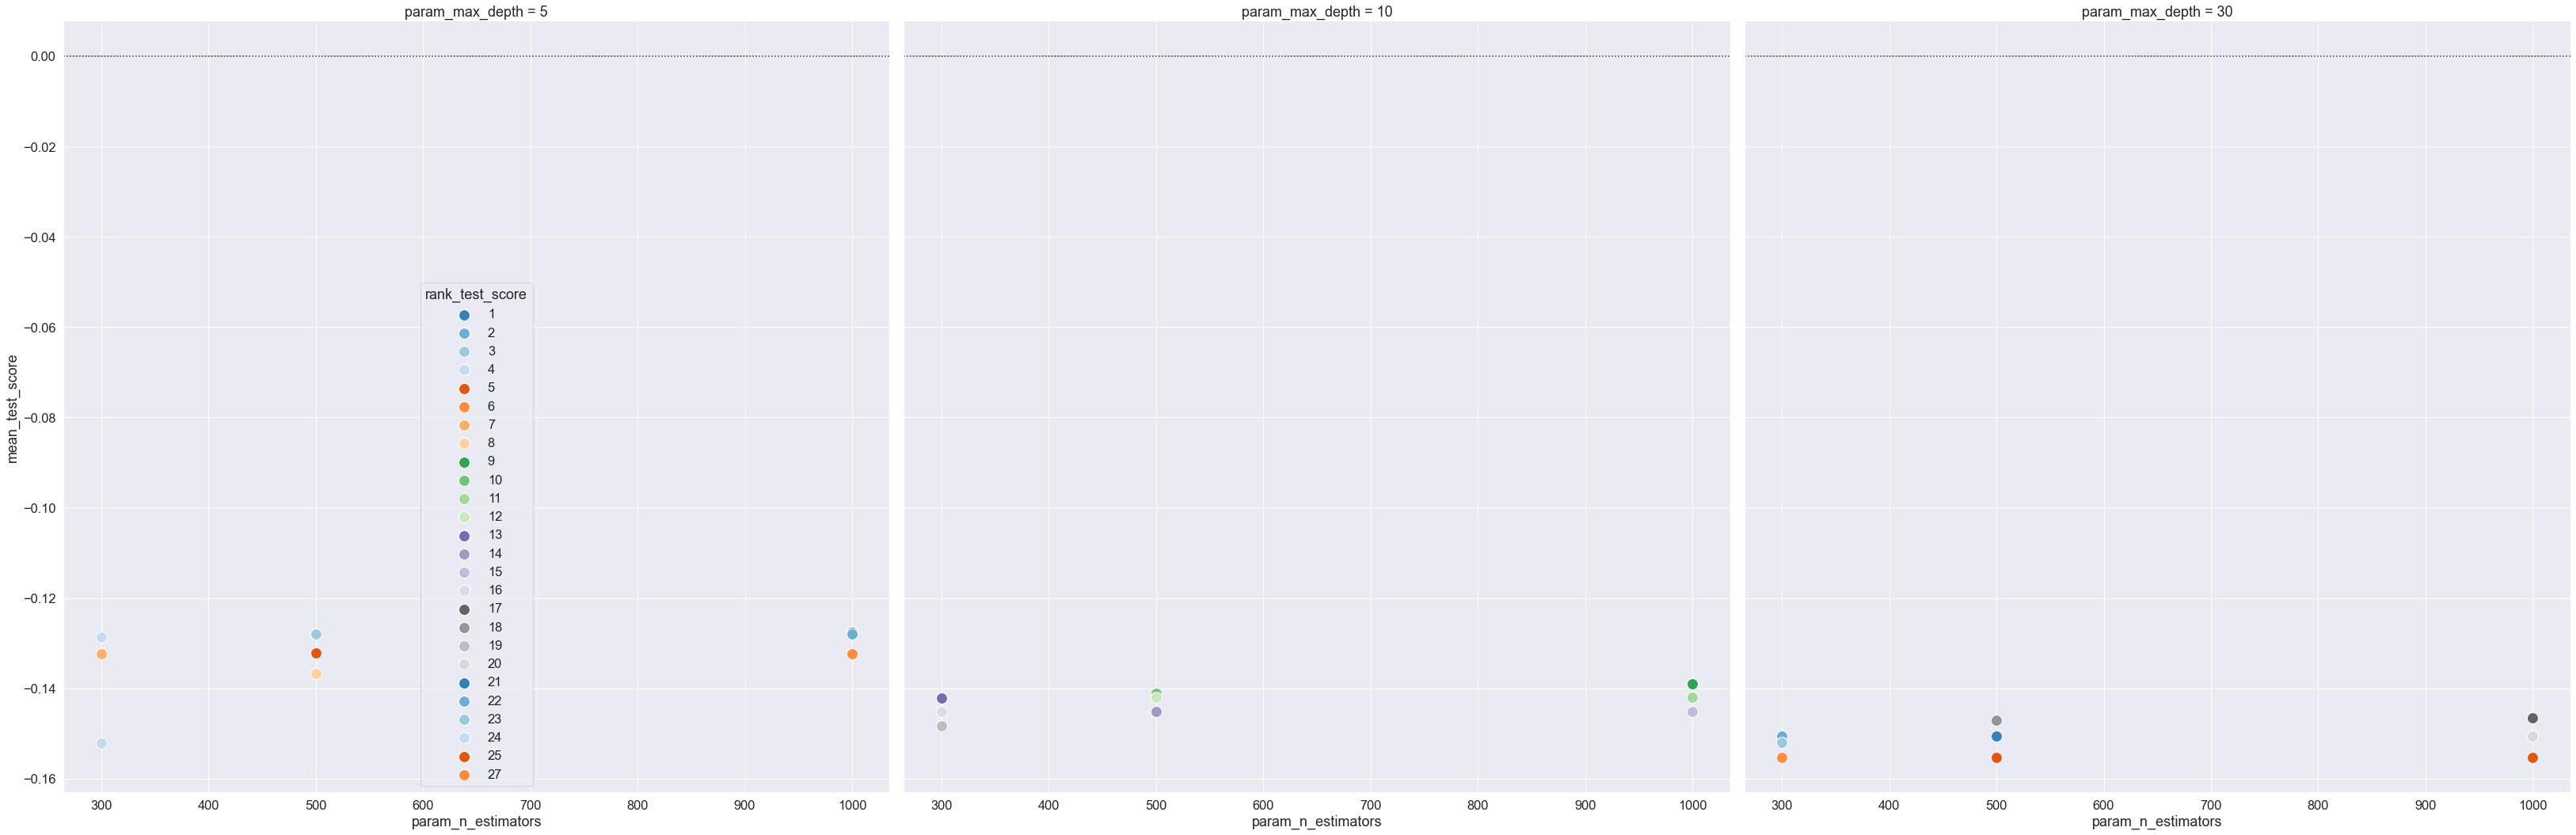

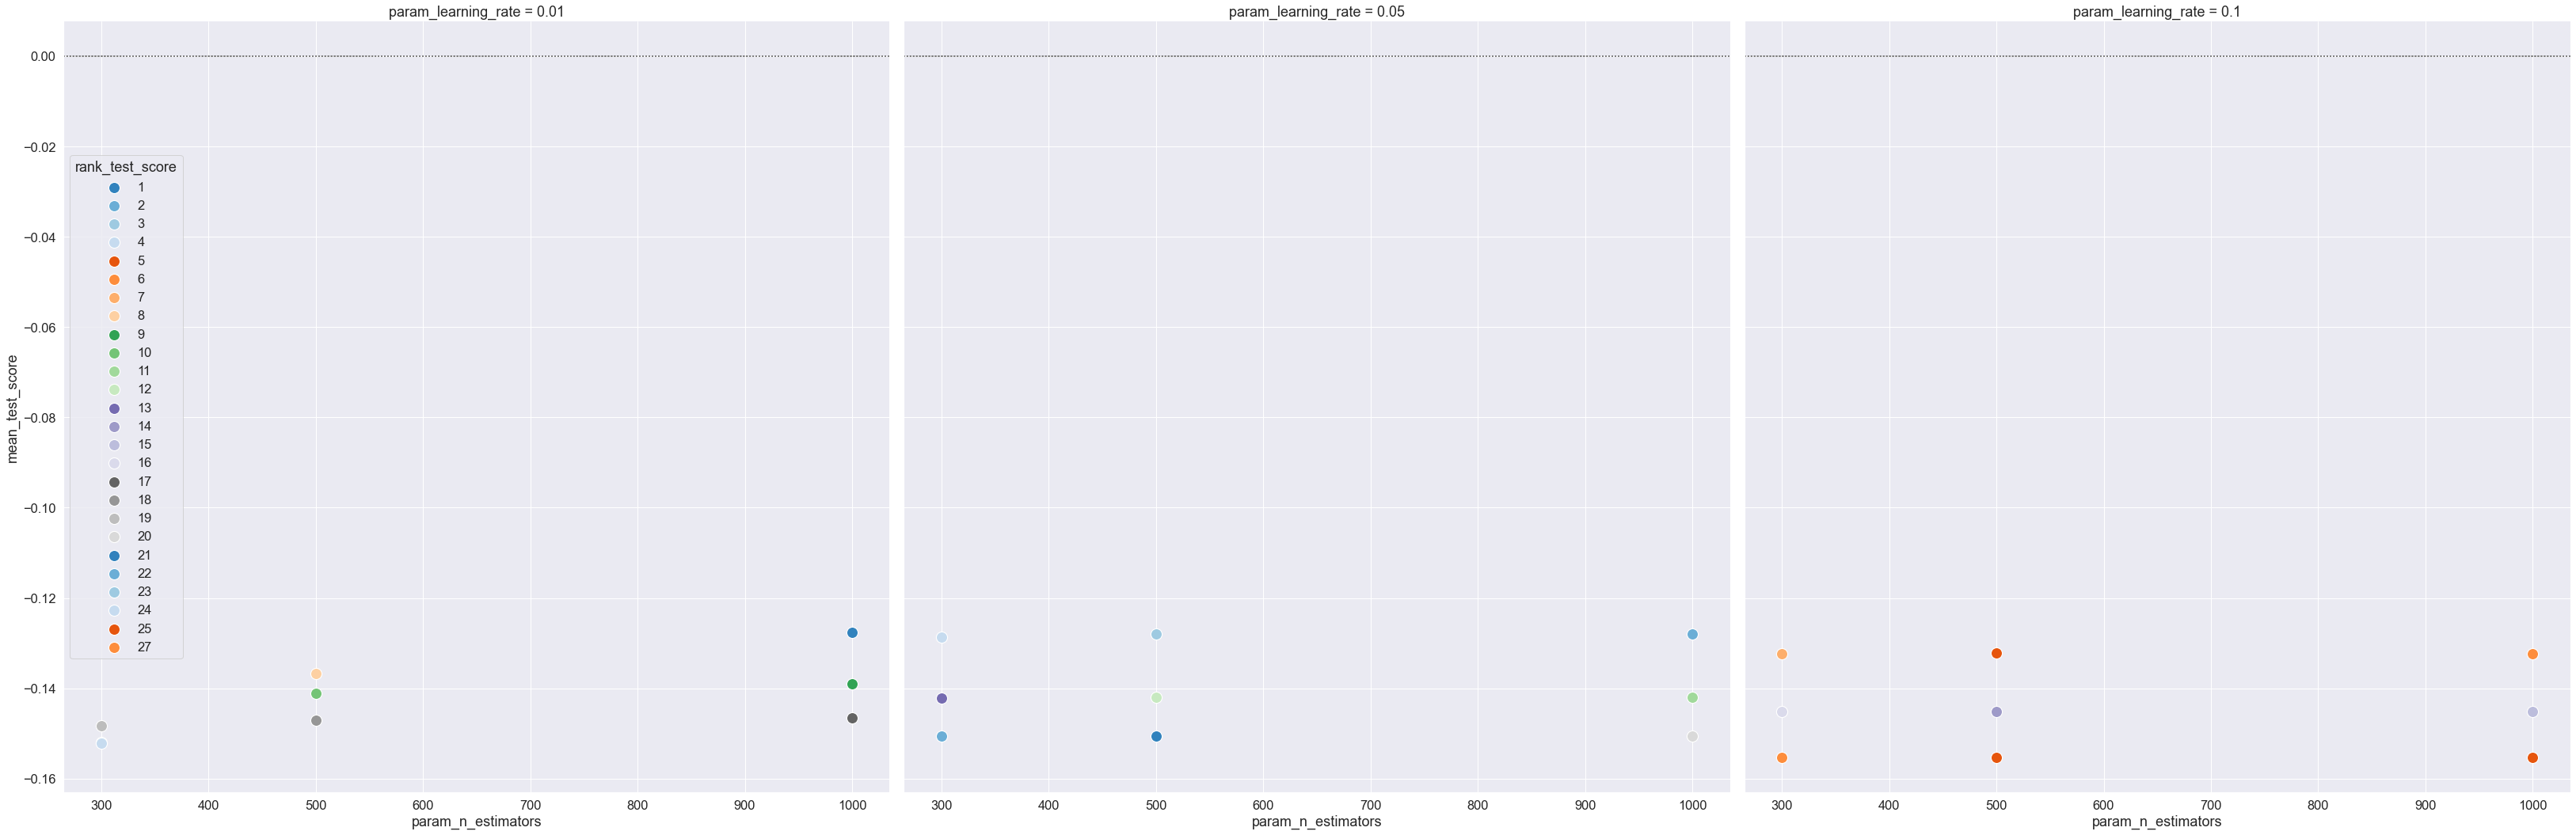

In [86]:
rand_forest_tuned_model.best_params_,rand_forest_tuned_model.best_score_

In [51]:
from sklearn.metrics import mean_absolute_error as mae
y_pred_grad = gra_boost_tuned_model.predict(X_test)
mae(y_pred_grad, y_test)


0.08462143587840439

In [53]:
y_pred_tree = tree_tuned_model.predict(X_test)
mae(y_pred_tree, y_test)

0.153760233362433

In [55]:
y_pred_rand = rand_forest_tuned_model.predict(X_test)
mae(y_pred_rand,y_test)

0.09526663877426517